# Perceptually Important Point

An algorithmic method for assessing statistically the efficient market hypothesis (EMH) is developed based on two data mining tools, perceptually important points (PIPs) used to dynamically segment price series into subsequences, and dynamic time warping (DTW) used to find similar historical subsequences.Nov 1, 2014


---

<img src = "https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/192218530b0aaa4c812bf1d603a63a5e676a1271/3-Figure2-1.png">

----

## 코드 출처 : https://github.com/intelie/python-fastpip

In [1]:
import logging as default_logging
import sys
import math

In [2]:


__all__ = ['pip']

logging = default_logging.getLogger('simentarweb:utils:charts')

INFINITY = float('inf')


class PipItem(object):

    def __init__(self, index, parent, **kwargs):
        self.index = index
        self.parent = parent
        self.cache = kwargs.get('cache', INFINITY)
        self.value = kwargs.get('value', None)
        self.order = kwargs.get('order', None)
        self.left = kwargs.get('left', None)
        self.right = kwargs.get('right', None)

    def update_cache(self):
        if None in (self.left, self.right):
            self.cache = INFINITY
        else:
            self.cache = self.parent.distance(self.left.value, self.value, self.right.value)
        self.parent.notify_change(self.index)

    def put_after(self, tail):
        if tail is not None:
            tail.right = self
            tail.update_cache()
        self.left = tail
        self.update_cache()
        return self

    def recycle(self):
        if self.left is None:
            self.parent.head = self.right
        else:
            self.left.right = self.right
            self.left.update_cache()

        if self.right is None:
            self.parent.tail = self.left
        else:
            self.right.left = self.left
            self.right.update_cache()

        return self.clear()

    def clear(self):
        self.order = 0
        self.left = None
        self.right = None
        self.cache = INFINITY

        ret = self.value
        self.value = None
        return ret


class PipHeap(object):

    def __init__(self, distance, **kwargs):
        self.distance = distance
        self.heap = self.create_heap(512)
        self.head = None
        self.tail = None
        self.size = 0
        self.global_order = 0

    def create_heap(self, size):
        return [PipItem(i, self) for i in range(size)]

    def ensure_heap(self, size):
        new_elements = [PipItem(i, self) for i in range(len(self.heap), size+1)]
        self.heap.extend(new_elements)

    def acquire_item(self, value):
        self.ensure_heap(self.size)
        item = self.heap[self.size]
        item.value = value

        self.size += 1
        self.global_order += 1
        item.order = self.global_order
        return item

    def add(self, value):
        self.tail = self.acquire_item(value).put_after(self.tail)
        if self.head is None:
            self.head = self.tail

    @property
    def min_value(self):
        return self.heap[0].cache

    def remove_min(self):
        return self.remove_at(0)

    def remove_at(self, index):
        self.size -= 1
        self.swap(index, self.size)
        self.bubble_down(index)
        return self.heap[self.size].recycle()

    def notify_change(self, index):
        return self.bubble_down(self.bubble_up(index))

    def bubble_up(self, n):
        while (n != 0) and self.less(n, (n-1)/2):
            n = self.swap(n, (n-1)/2)
        return n

    def bubble_down(self, n):
        get_k = lambda n: self.min(n, n*2+1, n*2+2)

        k = get_k(n)
        while (k != n) and (k < self.size):
            n = self.swap(n, k)
            k = get_k(n)
        return n

    def min(self, i, j, k=None):
        if k is not None:
            result = self.min(i, self.min(j, k))
        else:
            result = i if self.less(i, j) else j

        return result

    def less(self, i, j):
        def i_smaller_than_j(heap, i, j):
            i, j = int(i), int(j)
            if heap[i].cache != heap[j].cache:
                result = heap[i].cache < heap[j].cache
            else:
                result = heap[i].order < heap[j].order
            return result

        heap = self.heap
        return ((i < self.size) and (j >= self.size or i_smaller_than_j(heap, i, j)))

    def swap(self, i, j):
        i, j = int(i), int(j)
        self.heap[i].index, self.heap[j].index = j, i
        self.heap[i], self.heap[j] = self.heap[j], self.heap[i]
        return j

    def __iter__(self):
        current = self.head
        while current is not None:
            yield current.value
            current = current.right


def vertical_distance(left, current, right):
    EPSILON = 1e-06
    a_x, a_y = left
    b_x, b_y = current
    c_x, c_y = right

    if (abs(a_x - b_x) < EPSILON) or (abs(b_x - c_x) < EPSILON):
        result = 0
    elif (c_x - a_x) == 0:
        # Otherwise we could have a ZeroDivisionError
        result = INFINITY
    else:
        result = abs(((a_y + (c_y - a_y) * (b_x - a_x) / (c_x - a_x) - b_y)) * (c_x - a_x))

    return result


def dist(x1, x2, y1, y2):
    return math.sqrt((x1-x2)**2 + (y1-y2)**2)


def euclidean_distance(left, current, right):
    left_current = dist(left[0], current[0], left[1], current[1])
    rightcurrent = dist(right[0], current[0], right[1], current[1])
    return (left_current + rightcurrent) * (right[0] - left[0])


def pip(data, k, fast=True, stream_mode=True, distance='vertical'):
    distance_functions = {
        'vertical': vertical_distance,
        'euclidean': euclidean_distance,
    }
    distance_function = distance_functions[distance]

    if fast:
        result = fastpip(data, k, stream_mode=stream_mode, distance_function=distance_function)
    else:
        result = simplepip(data, k, distance_function=distance_function)

    return result


def fastpip(data, k, stream_mode=True, distance_function=vertical_distance):

    if len(data) >= k:
        heap = PipHeap(distance_function)

        for element in data:
            heap.add(element)

            if stream_mode and (heap.size > k):
                heap.remove_min()

        if not stream_mode:
            while heap.size > k:
                heap.remove_min()

        ret = list(heap)
    else:
        ret = data

    logging.debug("pip: started with {} points, returned {} points".format(len(data), len(ret)))
    return ret


def simplepip(data, k, distance_function=vertical_distance):
    ret = []

    for (idx, value) in enumerate(data):
        ret.append(value)
        if len(ret) <= k:
            continue

        miniv = sys.maxsize
        minij = 0

        for j in range(1, len(ret) - 1):
            d = distance_function(ret[j - 1], ret[j], ret[j + 1])
            if d < miniv:
                miniv = d
                minij = j

        del ret[minij]

    return ret

----

#### 라이브러리 불러오기

In [3]:
! pip install progressbar2

In [4]:
import pandas as pd
import time
import requests
from bs4 import BeautifulSoup as bs
import numpy as np
from datetime import datetime, timedelta
from progressbar import progressbar
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy import spatial


In [5]:
data = pd.read_csv('price_table.csv', encoding = 'euckr')

In [6]:
work = data[data['종목명'] == '현대건설']

In [7]:
work= work.reset_index()

In [8]:
work

,index,일자,code,시가,고가,저가,종가,거래량,종목명
0,42089,2018-02-19,A000720,40000,41700,39700,41300,708801,현대건설
1,42090,2018-02-20,A000720,41300,41800,40600,41150,427919,현대건설
2,42091,2018-02-21,A000720,41150,41150,39850,40050,522480,현대건설
3,42092,2018-02-22,A000720,40050,40050,38950,38950,606054,현대건설
4,42093,2018-02-23,A000720,39450,40500,39400,40250,638428,현대건설
5,42094,2018-02-26,A000720,40750,40750,39450,39900,427600,현대건설
6,42095,2018-02-27,A000720,39950,40100,39100,39150,593937,현대건설
7,42096,2018-02-28,A000720,39000,39450,38500,38500,543976,현대건설
8,42097,2018-03-02,A000720,38200,38400,37600,37800,433447,현대건설
9,42098,2018-03-05,A000720,37700,38250,37450,37450,262937,현대건설


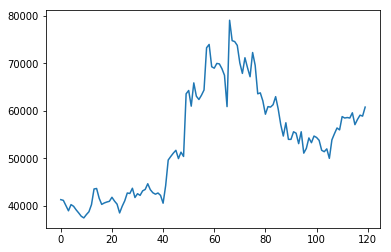

In [9]:
plt.plot(work['종가'])

In [10]:
work['종가'].values

array([41300, 41150, 40050, 38950, 40250, 39900, 39150, 38500, 37800,
       37450, 38150, 38750, 40250, 43550, 43650, 41600, 40300, 40600,
       40800, 40950, 41800, 41000, 40350, 38500, 39900, 41050, 42700,
       42600, 43700, 41750, 42550, 42200, 43150, 43450, 44650, 43400,
       42750, 42450, 42700, 42200, 40550, 44250, 49650, 50400, 51100,
       51700, 49950, 51300, 50400, 63600, 64300, 61000, 65900, 63100,
       62400, 63300, 64400, 73300, 74000, 69300, 69000, 70000, 69900,
       68900, 67500, 60900, 79100, 74800, 74600, 73800, 70100, 67900,
       71200, 69100, 67200, 72300, 69600, 63600, 63800, 62100, 59300,
       60900, 60800, 61300, 63000, 60400, 57100, 54700, 57500, 54000,
       54000, 55600, 55300, 53100, 55600, 51100, 52100, 54300, 53300,
       54700, 54400, 53800, 51700, 51400, 52000, 50000, 53900, 55200,
       56400, 56000, 58800, 58500, 58600, 58500, 59600, 57100, 58200,
       59100, 58900, 60800], dtype=int64)

In [11]:
pre_list = [(i, work['종가'].values[i]) for i in range(len(work['종가'].values))]

In [11]:
pre_list

[(0, 41300),
 (1, 41150),
 (2, 40050),
 (3, 38950),
 (4, 40250),
 (5, 39900),
 (6, 39150),
 (7, 38500),
 (8, 37800),
 (9, 37450),
 (10, 38150),
 (11, 38750),
 (12, 40250),
 (13, 43550),
 (14, 43650),
 (15, 41600),
 (16, 40300),
 (17, 40600),
 (18, 40800),
 (19, 40950),
 (20, 41800),
 (21, 41000),
 (22, 40350),
 (23, 38500),
 (24, 39900),
 (25, 41050),
 (26, 42700),
 (27, 42600),
 (28, 43700),
 (29, 41750),
 (30, 42550),
 (31, 42200),
 (32, 43150),
 (33, 43450),
 (34, 44650),
 (35, 43400),
 (36, 42750),
 (37, 42450),
 (38, 42700),
 (39, 42200),
 (40, 40550),
 (41, 44250),
 (42, 49650),
 (43, 50400),
 (44, 51100),
 (45, 51700),
 (46, 49950),
 (47, 51300),
 (48, 50400),
 (49, 63600),
 (50, 64300),
 (51, 61000),
 (52, 65900),
 (53, 63100),
 (54, 62400),
 (55, 63300),
 (56, 64400),
 (57, 73300),
 (58, 74000),
 (59, 69300),
 (60, 69000),
 (61, 70000),
 (62, 69900),
 (63, 68900),
 (64, 67500),
 (65, 60900),
 (66, 79100),
 (67, 74800),
 (68, 74600),
 (69, 73800),
 (70, 70100),
 (71, 67900),
 (

In [12]:
x = [i[0] for i in pre_list]
x

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119]

In [13]:
y = [i[1] for i in pre_list]
y

[41300,
 41150,
 40050,
 38950,
 40250,
 39900,
 39150,
 38500,
 37800,
 37450,
 38150,
 38750,
 40250,
 43550,
 43650,
 41600,
 40300,
 40600,
 40800,
 40950,
 41800,
 41000,
 40350,
 38500,
 39900,
 41050,
 42700,
 42600,
 43700,
 41750,
 42550,
 42200,
 43150,
 43450,
 44650,
 43400,
 42750,
 42450,
 42700,
 42200,
 40550,
 44250,
 49650,
 50400,
 51100,
 51700,
 49950,
 51300,
 50400,
 63600,
 64300,
 61000,
 65900,
 63100,
 62400,
 63300,
 64400,
 73300,
 74000,
 69300,
 69000,
 70000,
 69900,
 68900,
 67500,
 60900,
 79100,
 74800,
 74600,
 73800,
 70100,
 67900,
 71200,
 69100,
 67200,
 72300,
 69600,
 63600,
 63800,
 62100,
 59300,
 60900,
 60800,
 61300,
 63000,
 60400,
 57100,
 54700,
 57500,
 54000,
 54000,
 55600,
 55300,
 53100,
 55600,
 51100,
 52100,
 54300,
 53300,
 54700,
 54400,
 53800,
 51700,
 51400,
 52000,
 50000,
 53900,
 55200,
 56400,
 56000,
 58800,
 58500,
 58600,
 58500,
 59600,
 57100,
 58200,
 59100,
 58900,
 60800]

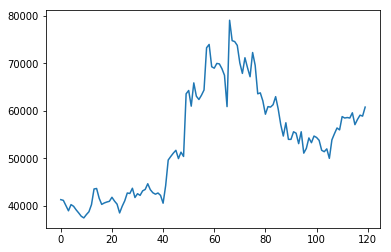

In [14]:
plt.plot(x,y)

### fastpip 함수 활용

In [14]:
pip_list = fastpip(pre_list, 20)
pip_list

[(0, 41300),
 (9, 37450),
 (14, 43650),
 (23, 38500),
 (34, 44650),
 (40, 40550),
 (42, 49650),
 (48, 50400),
 (49, 63600),
 (56, 64400),
 (57, 73300),
 (64, 67500),
 (66, 79100),
 (71, 67900),
 (76, 69600),
 (80, 59300),
 (85, 60400),
 (95, 51100),
 (105, 50000),
 (119, 60800)]

In [15]:
px = [i[0] for i in pip_list]
px

[0,
 9,
 14,
 23,
 34,
 40,
 42,
 48,
 49,
 56,
 57,
 64,
 66,
 71,
 76,
 80,
 85,
 95,
 105,
 119]

In [16]:
py = [i[1] for i in pip_list]
py

[41300,
 37450,
 43650,
 38500,
 44650,
 40550,
 49650,
 50400,
 63600,
 64400,
 73300,
 67500,
 79100,
 67900,
 69600,
 59300,
 60400,
 51100,
 50000,
 60800]

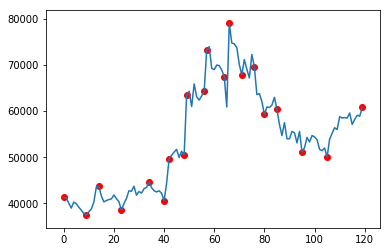

In [22]:
plt.plot(x,y)
plt.scatter(px,py, color='red')

In [17]:
pip_list2 = fastpip(pre_list, 8)
pip_list2

[(0, 41300),
 (23, 38500),
 (39, 42200),
 (48, 50400),
 (58, 74000),
 (65, 60900),
 (99, 54700),
 (119, 60800)]

In [34]:
px1 = [i[0] for i in pip_list2]
px1

[0, 23, 39, 48, 58, 65, 99, 119]

In [35]:
py1 = [i[1] for i in pip_list2]
py1

[41300, 38500, 42200, 50400, 74000, 60900, 54700, 60800]

In [44]:
plt.style.use('seaborn')

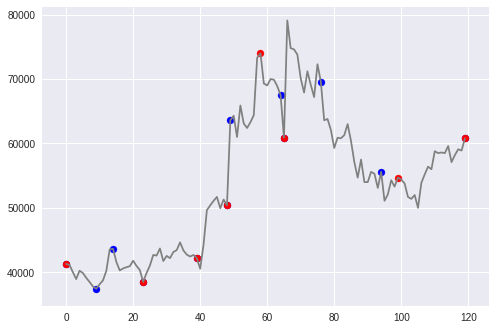

In [46]:
plt.plot(x,y, color = 'grey')
plt.scatter(px,py, color='blue')
plt.scatter(px1,py1, color='red')